In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm

%matplotlib inline
sns.set_style("whitegrid")

In [2]:
# Pauli matricies

si = qt.qeye(2)
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()

In [3]:
#### Simulation parameters ####
dt = 0.1
T = 50.0
times = np.arange(0.0, T+dt, dt)

N_cycles = 20       # Stevilo ciklov algoritma


#### TFIM system parameters ####
N = 3  # length of chain
N = 2*N # total number of sites

J = 1.0
hx = 1
hz = 1

#### Coupling and bath parameters ####
Jc = 0.8
Bi = 4.0
Bf = 0.0

hb = 0.8

tfim_parameters = [J, hx, hz]
bath_parameters = [hb, Bi, Bf, T]
coupling_parameters = [Jc, T]

time_dependant_functions_coeffs = {'Jc': Jc, 'T': T, 'Bi': Bi, 'Bf': Bf}

In [4]:
def generate_single_spin_state(phi:float, theta:float):
    return np.cos(theta/2) * qt.basis(2,0) + np.sin(theta/2) * np.exp(1j * phi) * qt.basis(2,1)

In [5]:
class pulseDrive():
    
    def __init__(self, magnitude:float, direction:str, t0:float, tmax:float) -> None:
          self.mag = magnitude
          self.dir = direction
          self.t0 = t0
          self.tmax = tmax

    def __repr__(self):
        return f"{self.dir} pulse magnitude {self.mag}: between {self.t0}, {self.tmax}"
    
    def __str__(self):
        return f"{self.dir} pulse magnitude {self.mag}: between {self.t0}, {self.tmax}"

    def drive(self,t):
        tmid = (self.tmax+self.t0)/2
        sigma = (self.tmax-self.t0)/6
        if t > self.t0 and t < self.tmax:
            return 1/2*self.mag*1/np.sqrt(2*np.pi*sigma**2) *np.exp(-(t-tmid)**2/(2*sigma**2))
        else:
            return 0


def list_to_pulseset(instruction: list, t0:float, tmax:float):
    x_set, z_set = [], []

    N = len(instruction)
    ts = np.linspace(t0, tmax, N+1)

    for i in range(N):
        if instruction[i][0] == "x":
             x_set.append(pulseDrive(instruction[i][1], "x", ts[i], ts[i+1]))
             z_set.append(pulseDrive(0, "z", ts[i], ts[i+1]))
        elif instruction[i][0] == "z":
             x_set.append(pulseDrive(0, "x", ts[i], ts[i+1]))
             z_set.append(pulseDrive(instruction[i][1], "z", ts[i], ts[i+1]))

    return x_set, z_set

def pulseset_to_function(pulse_set: list):
    
    def f(t):
        value = 0
        for pulse in pulse_set:
             value += pulse.drive(t)
        return value
    
    return f


def single_bit_rotation(psi0, instruction_list:list, t0:float, tmax:float):

    tlist = np.linspace(t0,tmax,100)
    x_set, z_set = list_to_pulseset(instruction_list, t0, tmax)
    f_x, f_z = pulseset_to_function(x_set), pulseset_to_function(z_set)
    
    """
    plt.plot(tlist, [f_x(t) for t in tlist], color = "red", label = "hx")
    plt.plot(tlist,  [f_z(t) for t in tlist], color = "green", label = "hz")
    plt.legend()
    plt.show()
    """
    

    H = [[sx, f_x], [sz, f_z]]

    result = qt.mesolve(H, psi0, tlist, args=[])

    psiEnd = result.states[-1]

    """
    vals = []
    for i in range(len(tlist)):
        vals.append(result.states[i][0,0])
    plt.plot(tlist,np.real(vals), label = "Re $\\rho_{00}$")
    vals = []
    for i in range(len(tlist)):
        vals.append(result.states[i][0,1])
    plt.plot(tlist,np.real(vals), label = "$Re \\rho_{01}$")
    vals = []
    for i in range(len(tlist)):
        vals.append(result.states[i][1,0])
    plt.plot(tlist,np.real(vals), label = "$Re \\rho_{10}$")
    vals = []
    for i in range(len(tlist)):
        vals.append(result.states[i][1,1])
    plt.plot(tlist,np.real(vals), label = "$Re \\rho_{11}$")
    plt.legend()
    plt.show()

    vals = []
    for i in range(len(tlist)):
        vals.append(result.states[i][0,0])
    plt.plot(tlist,np.imag(vals), label = "Im $\\rho_{00}$")
    vals = []
    for i in range(len(tlist)):
        vals.append(result.states[i][0,1])
    plt.plot(tlist,np.imag(vals), label = "$Im \\rho_{01}$")
    vals = []
    for i in range(len(tlist)):
        vals.append(result.states[i][1,0])
    plt.plot(tlist,np.imag(vals), label = "$Im \\rho_{10}$")
    vals = []
    for i in range(len(tlist)):
        vals.append(result.states[i][1,1])
    plt.plot(tlist,np.imag(vals), label = "$Im \\rho_{11}$")
    plt.legend()
    plt.show()

    print(psi0)
    print(psiEnd)
    """
    return psiEnd

#psi0 = qt.basis(2,0)
#psi0 = (qt.basis(2,0) + qt.basis(2,1))/np.sqrt(2)
psi0 = generate_single_spin_state(0,0)
psi0 = psi0 * psi0.dag()

##Exact measure
sx0 = qt.expect(sx,psi0)
sy0 = qt.expect(sy,psi0)
sz0 = qt.expect(sz,psi0)

##Measure via rotation
psi1 = single_bit_rotation(psi0, [["x",np.pi/2]], 0,1)
sy_rot = qt.expect(sz,psi1)

psi2 = single_bit_rotation(psi0, [["z",np.pi/2]], 0,1)
psi2 = single_bit_rotation(psi2, [["x",np.pi/2]], 0,1)
sx_rot = qt.expect(sz,psi2)

print(f"exact: ({sx0}, {sy0}, {sz0}), via rotation ({sx_rot}, {sy_rot}, {sz0})")










exact: (0.0, 0.0, 1.0), via rotation (0.004271177840292684, 0.004271177840292684, 1.0)


In [6]:
def TFIM_Hamiltonian(N, J, hx, hz):
    sx_list = []
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))

    J_list = np.ones(N) * J
    hx_list = np.ones(N) * hx
    hz_list = np.ones(N) * hz

    H_ising_chain = 0

    for n in range(N):
        H_ising_chain += -hx_list[n] * sx_list[n]
        H_ising_chain += -hz_list[n] * sz_list[n]

    for n in range(N):
        H_ising_chain += - J_list[n] * sz_list[n] * sz_list[((n+1)%N)]

    return H_ising_chain

def multilist_to_pulseset(N:int, instruction: list, t0:float, tmax:float):
    x_set, z_set = [[] for i in range(N)], [[] for i in range(N)] 

    """Instruction format = [[direction:string, magnitude:float, list of spins indices:list, time_order:int]]"""
    time_indices = set()
    for instr in instruction:
        if instr[0] == "x":
            for i in instr[2]:
                x_set[i].append([instr[1], instr[3]])
                time_indices.add(instr[3])
        elif instr[0] == "z":
            for i in instr[2]:
                z_set[i].append([instr[1], instr[3]])
                time_indices.add(instr[3])
        else:
            raise ValueError("Direction must be x or z")

    #for i in range(min(time_indices), max(time_indices)+1):
        #if i not in time_indices:
        #   raise ValueError("Time indices must have no holes between them")

    for i in range(N):
        x_set[i] = sorted(x_set[i], key = lambda x: x[1])
        z_set[i] = sorted(z_set[i], key = lambda x: x[1])

    time_indices = [x for x in range(min(time_indices), max(time_indices)+1)]
    n = len(time_indices)
    ts = np.linspace(t0, tmax, n+1)
    tis_to_edgevals = dict()

    for i in range(min(time_indices), max(time_indices)+1):
        tis_to_edgevals[time_indices[i]] = (ts[i],ts[i+1])
    
    for i in range(N):
        for j in range(len(x_set[i])):
            x_set[i][j][1] = tis_to_edgevals[x_set[i][j][1]]
        for j in range(len(z_set[i])):
            z_set[i][j][1] = tis_to_edgevals[z_set[i][j][1]]

    return x_set, z_set



def multipulseset_to_function(pulse_set: list):
    fs = [None for i in range(len(pulse_set))]

    for i in range(len(pulse_set)):

        def f(t):
            val = 0
            for spin in pulse_set[i]:
                val += pulseDrive(spin[0], "irrelevant", spin[1][0], spin[1][1]).drive(t)
            return val
        
        fs[i] = f

    return fs


def multi_bit_rotation(N, J, hx, hz, psi0, instruction_list:list, t0:float, tmax:float):
    tlist = np.linspace(t0,tmax,100)

    x_set, z_set = multilist_to_pulseset(N,instruction_list, t0, tmax)
    f_xs = multipulseset_to_function(x_set); f_zs = multipulseset_to_function(z_set)


    sx_list = []
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))

    #Create hamultonian
    H = [TFIM_Hamiltonian(N, J, hx, hz)]

    for i in range(N):
        H.append([sx_list[i], f_xs[i]])
        H.append([sz_list[i], f_zs[i]])

    
    result = qt.mesolve(H, psi0, tlist, args=[])

    """
    plt.plot(tlist, [f_xs[0](t) for t in tlist], color = "red", label = "hx")
    plt.plot(tlist,  [f_zs[0](t) for t in tlist], color = "green", label = "hz")
    plt.legend()
    plt.show()

    vals = []
    for i in range(len(tlist)):
        vals.append(result.states[i][0,0])
    plt.plot(tlist,np.real(vals), label = "Re $\\rho_{00}$")
    vals = []
    for i in range(len(tlist)):
        vals.append(result.states[i][0,1])
    plt.plot(tlist,np.real(vals), label = "$Re \\rho_{01}$")
    vals = []
    for i in range(len(tlist)):
        vals.append(result.states[i][1,0])
    plt.plot(tlist,np.real(vals), label = "$Re \\rho_{10}$")
    vals = []
    for i in range(len(tlist)):
        vals.append(result.states[i][1,1])
    plt.plot(tlist,np.real(vals), label = "$Re \\rho_{11}$")
    plt.legend()
    plt.show()

    vals = []
    for i in range(len(tlist)):
        vals.append(result.states[i][0,0])
    plt.plot(tlist,np.imag(vals), label = "Im $\\rho_{00}$")
    vals = []
    for i in range(len(tlist)):
        vals.append(result.states[i][0,1])
    plt.plot(tlist,np.imag(vals), label = "$Im \\rho_{01}$")
    vals = []
    for i in range(len(tlist)):
        vals.append(result.states[i][1,0])
    plt.plot(tlist,np.imag(vals), label = "$Im \\rho_{10}$")
    vals = []
    for i in range(len(tlist)):
        vals.append(result.states[i][1,1])
    plt.plot(tlist,np.imag(vals), label = "$Im \\rho_{11}$")
    plt.legend()
    plt.show()
    """
    
    psiEnd = result.states[-1]

    return psiEnd


In [7]:
# SINGLE BIT TEST 
psi0 = qt.basis(2,0)
psi0 = psi0 * psi0.dag()

psi1 = multi_bit_rotation(N=1,J=0,hx=0,hz=0,psi0=psi0, instruction_list=[["x", np.pi/2, [0], 0], ["z", np.pi/2, [0], 1], ["x", np.pi/2, [0], 2]], t0=0,tmax=1)
print(psi0)
print(psi1)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]]
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.49789343+0.j        0.49999099+0.0021406j]
 [0.49999099-0.0021406j 0.50210341+0.j       ]]


In [8]:
def make_operator_lists(N:int):
    sx_list = []
    sy_list = []
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))

        op_list[n] = sy
        sy_list.append(qt.tensor(op_list))

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))

    return sx_list, sy_list, sz_list

In [9]:
#ROTATING THE ENTIRE CHAIN AT ONCE

N = 5
J = 1
hx = 0
hz = 0
pulse_time = 0.01

#startstate collection!
all_up = qt.tensor([qt.basis(2,0) for i in range(N)])
all_down = qt.tensor([qt.basis(2,1) for i in range(N)])
all_in_x = qt.tensor([(qt.basis(2,0) + qt.basis(2,1))/np.sqrt(2) for i in range(N)])

phi = [0 for i in range(N)]
theta = [0 for i in range(N)]
custom = qt.tensor([generate_single_spin_state(phi[i], theta[i]) for i in range(N)])


psi0 = custom
psi0 = psi0 * psi0.dag()

#Measure exact values
sx_list, sy_list, sz_list = make_operator_lists(N)

exactX, exactY, exactZ = [None for i in range(N)], [None for i in range(N)], [None for i in range(N)]
for i in range(N):
    exactX[i] = qt.expect(sx_list[i], psi0)
    exactY[i] = qt.expect(sy_list[i], psi0)
    exactZ[i] = qt.expect(sz_list[i], psi0)

#Global pi/2 x rotation to y axis
instruction_list = [["x", np.pi/2, [i for i in range(N)], 0]]
psi1 = multi_bit_rotation(N=N, J=J, hx=hx, hz=hz, psi0=psi0, instruction_list=instruction_list, t0=0, tmax = pulse_time)

rotationY = [None for i in range(N)]
for i in range(N):
    rotationY[i] = qt.expect(sz_list[i], psi1)


#Global pi/2 z, pi/2 x rotation to x axis
instruction_list = [["z", np.pi/2, [i for i in range(N)], 0]]
psi2 = multi_bit_rotation(N=N, J=J, hx=hx, hz=hz, psi0=psi0, instruction_list=instruction_list, t0=0, tmax = pulse_time)
instruction_list = [["x", np.pi/2, [i for i in range(N)], 0]]
psi2 = multi_bit_rotation(N=N, J=J, hx=hx, hz=hz, psi0=psi2, instruction_list=instruction_list, t0=0, tmax = pulse_time)

rotationX = [None for i in range(N)]
for i in range(N):
    rotationX[i] = qt.expect(sz_list[i], psi2)


print("{:13}".format(" ") + "{:10}".format("Exact X") + "{:1}".format(" | ") + "{:10}".format("Rotation X") + "{:1}".format(" || ") + "{:10}".format("Exact Y") + "{:1}".format(" | ") + "{:10}".format("Rotation Y") + "{:1}".format(" || ") + "{:10}".format("Exact Z"))
for i in range(N):
    print("{:10}".format(f"Spin {i}:") + " | " + "{:10f}".format(exactX[i]) + "{:1}".format(" | ") + "{:10f}".format(rotationX[i]) + "{:1}".format(" || ") + "{:10f}".format(exactY[i]) + "{:1}".format(" | ") + "{:10f}".format(rotationY[i]) + "{:1}".format(" || ") + "{:10f}".format(exactZ[i]))




             Exact X    | Rotation X || Exact Y    | Rotation Y || Exact Z   
Spin 0:    |   0.000000 |   0.004272 ||   0.000000 |   0.004272 ||   1.000000
Spin 1:    |   0.000000 |   0.004272 ||   0.000000 |   0.004272 ||   1.000000
Spin 2:    |   0.000000 |   0.004272 ||   0.000000 |   0.004272 ||   1.000000
Spin 3:    |   0.000000 |   0.004272 ||   0.000000 |   0.004272 ||   1.000000
Spin 4:    |   0.000000 |   0.004272 ||   0.000000 |   0.004272 ||   1.000000


100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

[0.0017127309056411688, 1.2768303681537347]
[0.0018538465734657293, 1.3820312315860683]


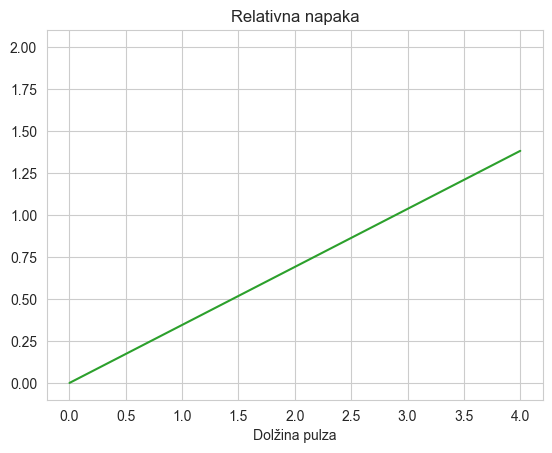

In [10]:
N = 5
J = 0.5
hx = 0.5
hz = 0

def error_by_interval(pulse_time, starte=None):
    #startstate collection!
    all_up = qt.tensor([qt.basis(2,0) for i in range(N)])
    all_down = qt.tensor([qt.basis(2,1) for i in range(N)])
    all_in_x = qt.tensor([(qt.basis(2,0) + qt.basis(2,1))/np.sqrt(2) for i in range(N)])

    phi = [np.pi/8 for i in range(N)]
    theta = [np.pi/2 for i in range(N)]
    custom = qt.tensor([generate_single_spin_state(phi[i], theta[i]) for i in range(N)])

    if starte is None:
        psi0 = custom
    else:
        psi0 = starte
        
    psi0 = psi0 * psi0.dag()

    #Measure exact values
    sx_list, sy_list, sz_list = make_operator_lists(N)

    exactX, exactY, exactZ = [None for i in range(N)], [None for i in range(N)], [None for i in range(N)]
    for i in range(N):
        exactX[i] = qt.expect(sx_list[i], psi0)
        exactY[i] = qt.expect(sy_list[i], psi0)
        exactZ[i] = qt.expect(sz_list[i], psi0)

    #Global pi/2 x rotation to y axis
    instruction_list = [["x", np.pi/2, [i for i in range(N)], 0]]
    psi1 = multi_bit_rotation(N=N, J=J, hx=hx, hz=hz, psi0=psi0, instruction_list=instruction_list, t0=0, tmax = pulse_time)

    rotationY = [None for i in range(N)]
    for i in range(N):
        rotationY[i] = qt.expect(sz_list[i], psi1)


    #Global pi/2 z, pi/2 x rotation to x axis
    instruction_list = [["z", np.pi/2, [i for i in range(N)], 0]]
    psi2 = multi_bit_rotation(N=N, J=J, hx=hx, hz=hz, psi0=psi0, instruction_list=instruction_list, t0=0, tmax = pulse_time)
    instruction_list = [["x", np.pi/2, [i for i in range(N)], 0]]
    psi2 = multi_bit_rotation(N=N, J=J, hx=hx, hz=hz, psi0=psi2, instruction_list=instruction_list, t0=0, tmax = pulse_time)

    rotationX = [None for i in range(N)]
    for i in range(N):
        rotationX[i] = qt.expect(sz_list[i], psi2)

    return exactX[0], rotationX[0]

abserror, relerror = [], []
durations = np.linspace(0.001, 4, 2)

for i in tqdm(range(len(durations))):
    duration = durations[i]
    exact, rotated = error_by_interval(duration)
    abserror.append(np.abs(exact-rotated))
    try:
        relerror.append(np.abs(abserror[-1]/exact))
    except ZeroDivisionError:
        relerror.append(-1)

print(abserror)
print(relerror)

#plt.plot(2,1,1)
#plt.plot(durations, abserror)
#plt.title("Absolutna napaka")
#plt.xlabel("Dolžina pulza")

#plt.show()

plt.plot(2,1,2)
plt.plot(durations, relerror)
plt.title("Relativna napaka")
plt.xlabel("Dolžina pulza")

plt.show()






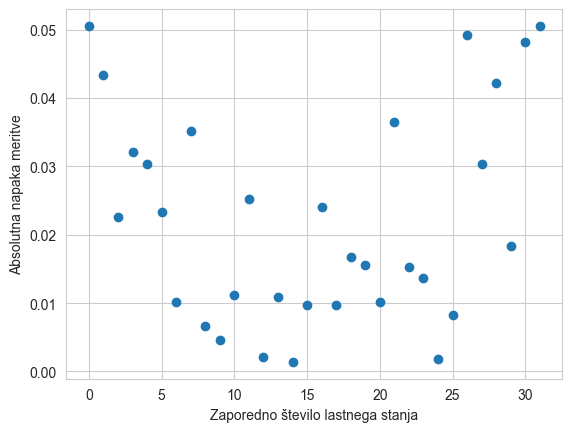

In [23]:
from pulses_lib import __TFIM_Hamiltonian as TFIM_H

N = 5
J = 0
hx = 1
hz = 0

H = TFIM_H(N,J,hx,hz)

eigenenergies, eigenstates = H.eigenstates()

#print(eigenenergies)
#print(eigenstates)


abserror, relerror = [], []
for state in eigenstates:
    exact, rotated = error_by_interval(0.1, starte=state)
    abserror.append(np.abs(exact-rotated))
    try:
        relerror.append(np.abs(abserror[-1]/exact))
    except ZeroDivisionError:
        relerror.append(-1)

plt.scatter([i for i in range(len(eigenstates))], abserror)
plt.xlabel("Zaporedno število lastnega stanja")
plt.ylabel("Absolutna napaka meritve")
#plt.show()

#plt.scatter([i for i in range(len(eigenstates))], relerror)
plt.show()